<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Inhalt
1. Wie sehen die Daten aus? Was für Informationen können wir daraus ziehen?
2. Grobe Metriken zu Schweizer Officers und deren Offshore Firmen.
3. ...

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from functools import reduce
import ast
from tqdm.notebook import tqdm
import copy

# Daten laden

In [2]:
def remove_special_characters(text):
    # Stellen Sie sicher, dass der Text ein String ist
    if isinstance(text, str):
        # Entfernt alles außer Buchstaben, Ziffern, Leerzeichen und grundlegenden Satzzeichen
        return re.sub(r'[^\w\s,.]', '', text)
    return text

if not os.path.exists("./data/graph.gexf"):
    nodes_addresses = pd.read_csv("./data/nodes-addresses.csv", low_memory=False, index_col=0).astype(str).map(remove_special_characters)
    nodes_addresses["node_type"] = ["Address"]*len(nodes_addresses)

    nodes_entities = pd.read_csv("./data/nodes-entities.csv", low_memory=False, index_col=0).astype(str).map(remove_special_characters)
    nodes_entities["node_type"] = ["Entity"]*len(nodes_entities)

    nodes_intermediaries = pd.read_csv("./data/nodes-intermediaries.csv", low_memory=False, index_col=0).astype(str).map(remove_special_characters)
    nodes_intermediaries["node_type"] = ["Intermediary"]*len(nodes_intermediaries)

    nodes_officers = pd.read_csv("./data/nodes-officers.csv", low_memory=False, index_col=0).astype(str).map(remove_special_characters)
    nodes_officers["node_type"] = ["Officer"]*len(nodes_officers)

    nodes_others = pd.read_csv("./data/nodes-others.csv", low_memory=False, index_col=0).astype(str).map(remove_special_characters)
    nodes_others["node_type"] = ["Other"]*len(nodes_others)

    relationships = pd.read_csv("./data/relationships.csv", low_memory=False).set_index(["node_id_start", "node_id_end"]).astype(str).map(remove_special_characters)

    G = nx.MultiDiGraph() #directed multi-edge graph
    G.add_nodes_from([(key, value) for key, value in nodes_addresses.to_dict("index").items()])
    G.add_nodes_from([(key, value) for key, value in nodes_entities.to_dict("index").items()])
    G.add_nodes_from([(key, value) for key, value in nodes_intermediaries.to_dict("index").items()])
    G.add_nodes_from([(key, value) for key, value in nodes_officers.to_dict("index").items()])
    G.add_nodes_from([(key, value) for key, value in nodes_others.to_dict("index").items()])
    G.add_edges_from([(*relationships.index[i], value) for i, value in enumerate(relationships.to_dict(orient='records'))])

    del nodes_addresses
    del nodes_entities
    del nodes_intermediaries
    del nodes_officers
    del nodes_others
    del relationships

    nx.write_gexf(G, "./data/graph.gexf")

    del G

graph:nx.MultiGraph = nx.read_gexf("./data/graph.gexf").to_undirected() #read and remove directions

#reduce graph to connected components which contain a swiss address
swiss_components = []
for component in nx.connected_components(graph):
    if "CHE" in list(nx.get_node_attributes(graph.subgraph([node for node in component if graph.nodes[node]["node_type"] == "Address"]), "country_codes").values()):
        swiss_components.append(component)

connected_to_swiss = nx.MultiGraph(graph.subgraph(set.union(*swiss_components)))

del graph

print("Number of edges: ", connected_to_swiss.number_of_edges())
print("Number of nodes: ", connected_to_swiss.number_of_nodes())
print("Number of connected components: ", nx.number_connected_components(connected_to_swiss))

Number of edges:  2308052
Number of nodes:  1441966
Number of connected components:  374


# How many nodes of what type

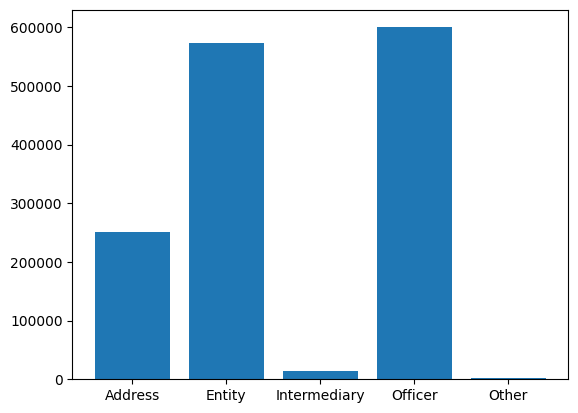

In [3]:
consistency = np.array(list(zip(*np.unique(list(nx.get_node_attributes(connected_to_swiss, 'node_type').values()), return_counts=True))))

plt.bar(consistency[:, 0], consistency[:, 1].astype(int))
plt.show()

# number of connected components

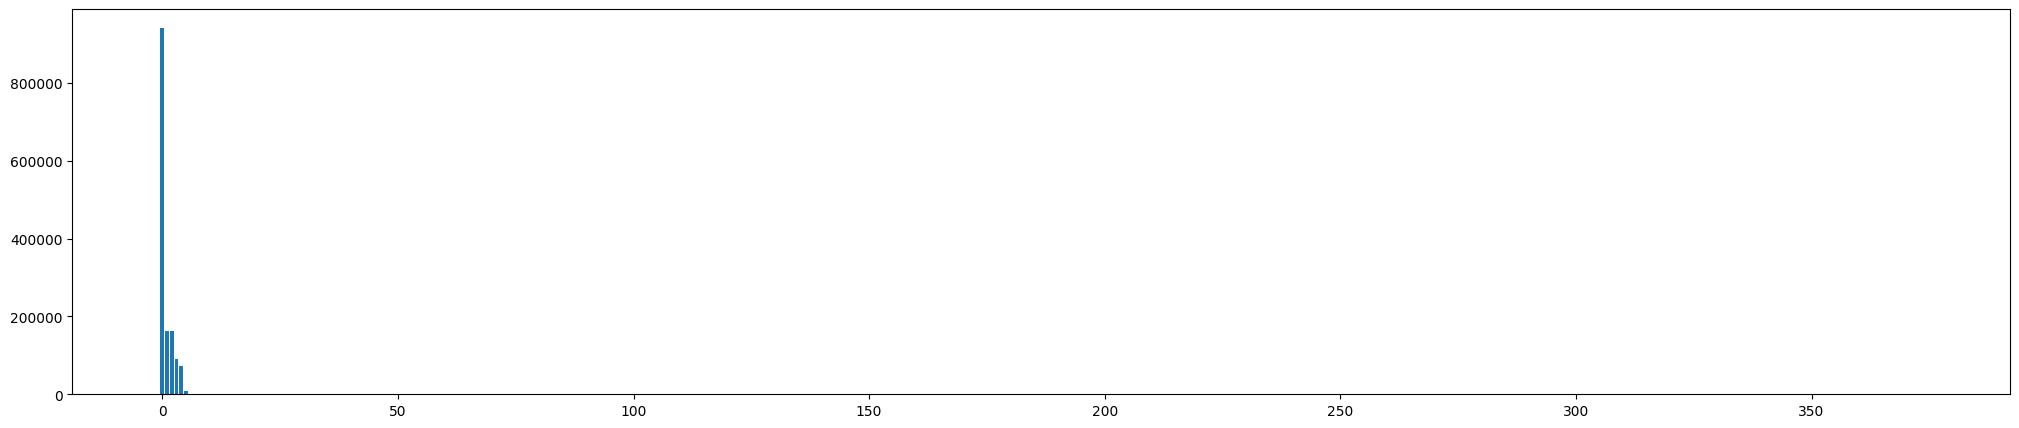

In [4]:
connected_components = np.array([c for c in sorted(nx.connected_components(connected_to_swiss), key=len, reverse=True)])

plt.figure(figsize=(25,5))
plt.bar(range(len(connected_components)), [len(c) for c in connected_components])
plt.show()

In [5]:
officer_graph = nx.bipartite.collaboration_weighted_projected_graph(nx.Graph(connected_to_swiss), [node for node, data in connected_to_swiss.nodes(data=True) if data["node_type"] == "Officer"])

# Officers density (network metrics)

In [6]:
# density of officers
nx.density(officer_graph)

0.00021176374397389924

In [7]:
# density of swiss officers
nx.density(officer_graph.subgraph([node for node, data in connected_to_swiss.nodes(data=True) if data["node_type"] == "Officer" and data.get("country_codes", "") == "CHE"]))

0.0019787281956003115

# group centrality

In [ ]:
swiss_officer_nodes = [node for node, data in connected_to_swiss.nodes(data=True) if data["node_type"] == "Officer" and data.get("country_codes", "") == "CHE"]
target_node = swiss_officer_nodes[0]
swiss_officer_nodes = swiss_officer_nodes[1:]

G_global_view = copy.deepcopy(officer_graph)

for node in  tqdm(swiss_officer_nodes):
    nx.contracted_nodes(G_global_view, target_node, node, self_loops=False, copy=False)

In [26]:
# what is the percentage of connections from swiss officers to all the other officers (group degree centrality)
nx.degree_centrality(G_global_view)[target_node]

0.050456759803758196

In [27]:
# group closeness centrality
nx.closeness_centrality(G_global_view, target_node)

0.29905522701259946

In [32]:
#group betweenness centrality
nx.betweenness_centrality_subset(G_global_view, G_global_view.nodes, targets=[target_node], normalized=True)

KeyboardInterrupt: 

## Grobe Metriken zu schweizer Officers und deren Offshore Firmen.

## ...